In [6]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import sqlite3
import plotly.express as px
import us
from ipywidgets import widgets, interact
import plotly.graph_objects as go
from datetime import datetime

In [2]:
df = pd.read_excel("Health_Science_Dataset.xlsx", header=1)
df
print(df.columns.tolist())


['Data As Of', 'Start Week', 'End Week', 'MMWRyear', 'MMWRweek', 'Week Ending Date', 'Group', 'Indicator', 'Jurisdiction', 'Age Group', 'COVID-19 Deaths', 'Total Deaths', 'Pneumonia Deaths', 'Influenza Deaths', 'Pneumonia or Influenza', 'Pneumonia, Influenza, or COVID-19 Deaths']


In [26]:
for col_idx in [6, 7, 8, 9]:
    col_name = df.columns[col_idx]
    df[col_name] = df[col_name].astype(str)

# Dates
for col_idx in [0, 1, 2, 5]:
    col_name = df.columns[col_idx]
    df[col_name] = pd.to_datetime(df[col_name], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Year
df['MMWRyear'] = df['MMWRyear'].astype(int)

# Integer
for col_idx in [4] + list(range(10, 16)):
    col_name = df.columns[col_idx]
    df[col_name] = df[col_name].apply(lambda x: int(x) if pd.notna(x) else x)


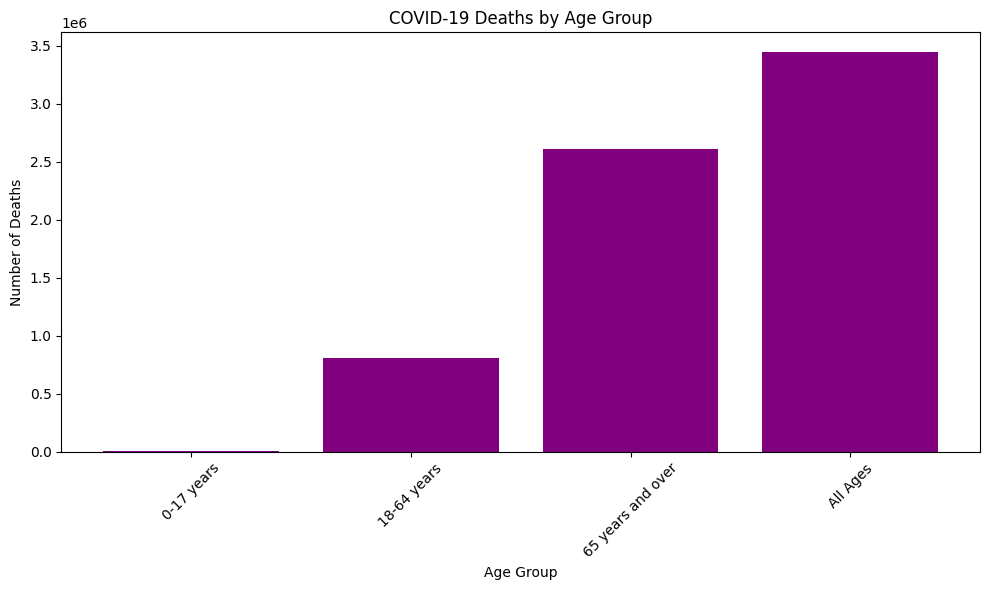

In [28]:
covid_deaths_by_age = df.groupby('Age Group')['COVID-19 Deaths'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(covid_deaths_by_age['Age Group'], covid_deaths_by_age['COVID-19 Deaths'], color='purple')
plt.title('COVID-19 Deaths by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

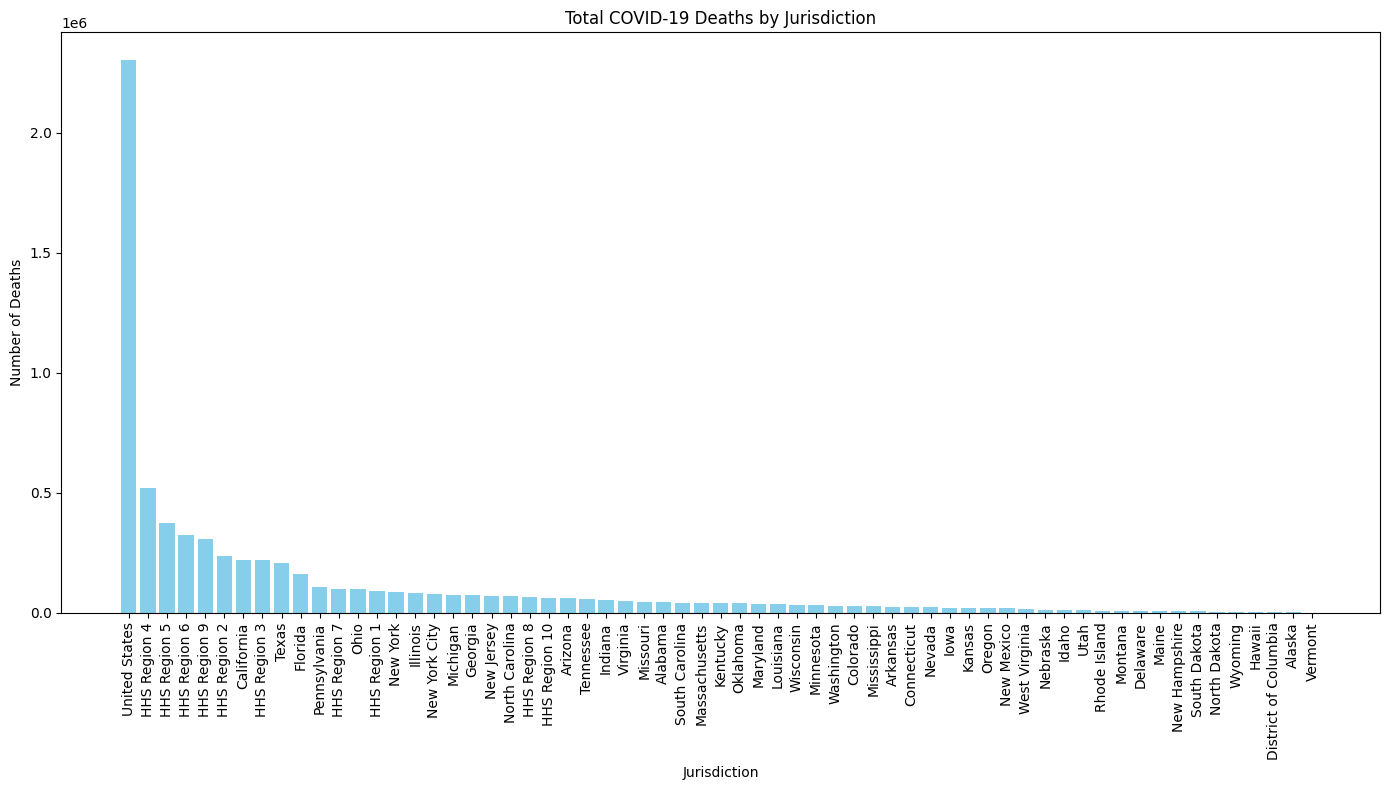

In [30]:
# Group by 'Jurisdiction' and sum the 'COVID-19 Deaths'
covid_deaths_by_jurisdiction = df.groupby('Jurisdiction')['COVID-19 Deaths'].sum().sort_values(ascending=False).reset_index()

# Plotting
plt.figure(figsize=(14, 8))
plt.bar(covid_deaths_by_jurisdiction['Jurisdiction'], covid_deaths_by_jurisdiction['COVID-19 Deaths'], color='skyblue')
plt.title('Total COVID-19 Deaths by Jurisdiction')
plt.xlabel('Jurisdiction')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [3]:

df_cleaned = df[['COVID-19 Deaths', 'Pneumonia Deaths', 'Influenza Deaths']]
df_cleaned = df_cleaned.apply(pd.to_numeric, errors='coerce')
df_cleaned = df_cleaned.dropna()


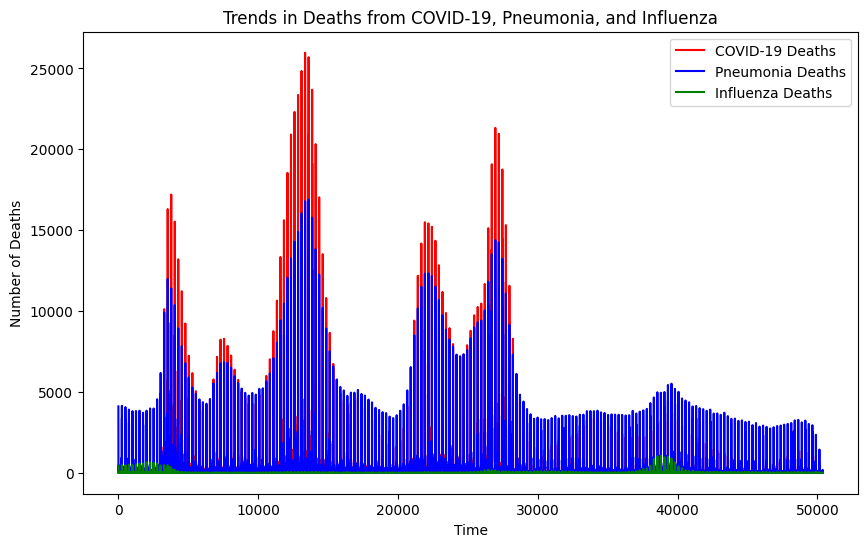

In [4]:


# Plot the time series trends for COVID-19, Pneumonia, and Influenza deaths
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned.index, df_cleaned['COVID-19 Deaths'], label='COVID-19 Deaths', color='r')
plt.plot(df_cleaned.index, df_cleaned['Pneumonia Deaths'], label='Pneumonia Deaths', color='b')
plt.plot(df_cleaned.index, df_cleaned['Influenza Deaths'], label='Influenza Deaths', color='g')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of Deaths')
plt.title('Trends in Deaths from COVID-19, Pneumonia, and Influenza')
plt.show()


In [5]:
correlation_matrix = df_cleaned.corr()

correlation_matrix

,COVID-19 Deaths,Pneumonia Deaths,Influenza Deaths
COVID-19 Deaths,1.000000,0.947707,0.225078
Pneumonia Deaths,0.947707,1.000000,0.375951
Influenza Deaths,0.225078,0.375951,1.000000


In [6]:
from sklearn.linear_model import LinearRegression

# Define the independent variable (e.g., Pneumonia and Influenza deaths) and dependent variable (COVID-19 deaths)
X = df_cleaned[['Pneumonia Deaths', 'Influenza Deaths']]
y = df_cleaned['COVID-19 Deaths']

# Create and train the regression model
reg_model = LinearRegression()
reg_model.fit(X, y)

# Get the regression coefficients
reg_model.coef_

array([ 1.25266214, -5.25763648])

/var/folders/c1/rgwjffqd0lddvp6pqnv2s8br0000gn/T/ipykernel_87986/1403270940.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Week Ending Date'] = pd.to_datetime(df_filtered['Week Ending Date'])
/var/folders/c1/rgwjffqd0lddvp6pqnv2s8br0000gn/T/ipykernel_87986/1403270940.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['COVID-19 Deaths'] = pd.to_numeric(df_filtered['COVID-19 Deaths'], errors='coerce')
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanp

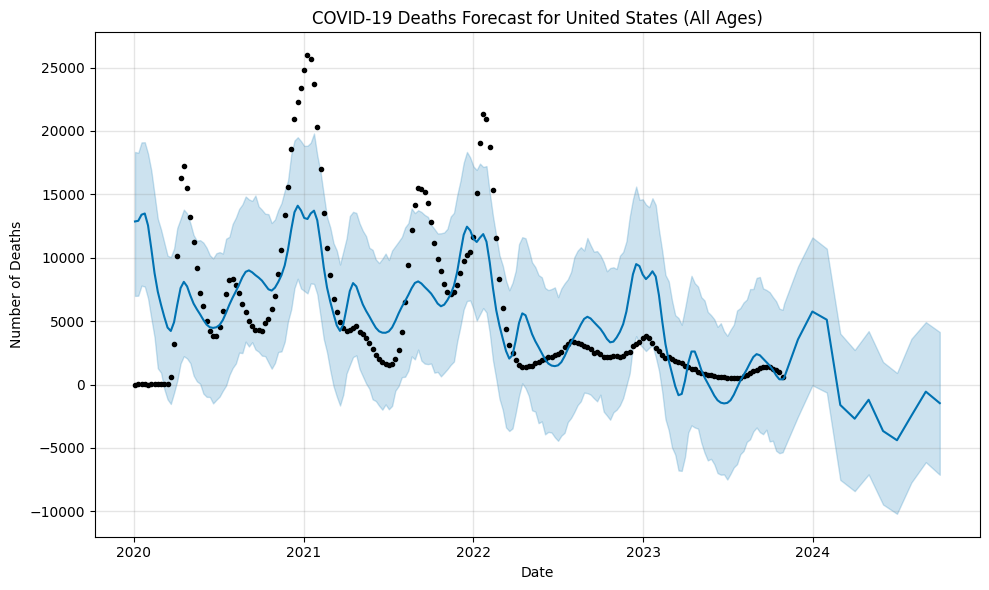

In [26]:
from prophet import Prophet

data = pd.ExcelFile("Health_Science_Dataset.xlsx")
df = data.parse('Sheet 1 - Provisional_Death_Cou')

df.columns = ['Data As Of', 'Start Week', 'End Week', 'MMWR Year', 'MMWR Week', 'Week Ending Date',
              'Group', 'Indicator', 'Jurisdiction', 'Age Group', 'COVID-19 Deaths', 
              'Total Deaths', 'Pneumonia Deaths', 'Influenza Deaths', 'Pneumonia or Influenza',
              'Pneumonia, Influenza, or COVID-19 Deaths']

# Filter for 'United States' and 'All Ages'
df_filtered = df[(df['Jurisdiction'] == 'United States') & (df['Age Group'] == 'All Ages')]

# Convert 'Week Ending Date' to datetime and COVID-19 Deaths to numeric
df_filtered['Week Ending Date'] = pd.to_datetime(df_filtered['Week Ending Date'])
df_filtered['COVID-19 Deaths'] = pd.to_numeric(df_filtered['COVID-19 Deaths'], errors='coerce')

# Prepare data for Prophet
df_prophet = df_filtered[['Week Ending Date', 'COVID-19 Deaths']].dropna().copy()
df_prophet.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (value to predict)

# Initialize the Prophet model and fit the data
model = Prophet()
model.fit(df_prophet)

# Make future predictions (for the next 12 months)
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)

# Customize the scatter plot for actual data points
plt.scatter(df_prophet['ds'], df_prophet['y'], color='k', s=5, alpha=0.7)  # Smaller points, added transparency
plt.title('COVID-19 Deaths Forecast for United States (All Ages)')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.tight_layout()
plt.show()

In [36]:
df = pd.read_csv("flights_sample_3m.csv")
print(df.shape[0])

3000000


In [31]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

# Filter Dates
start_date = pd.to_datetime('2019-12-29')
end_date = pd.to_datetime('2023-10-28')

df_filtered = df[(df['FL_DATE'] >= start_date) & (df['FL_DATE'] <= end_date)]

df_filtered.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN
6,2023-06-11,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2134,DCA,"Washington, DC",BOS,"Boston, MA",...,0.0,109.0,89.0,58.0,399.0,NaN,NaN,NaN,NaN,NaN


In [35]:
print(df_filtered.shape[0])
print(df_filtered.columns.tolist())

2248508
['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']


In [38]:
disease_df = pd.read_excel("Health_Science_Dataset.xlsx", header=1)
print(disease_df.columns.tolist())

['Data As Of', 'Start Week', 'End Week', 'MMWRyear', 'MMWRweek', 'Week Ending Date', 'Group', 'Indicator', 'Jurisdiction', 'Age Group', 'COVID-19 Deaths', 'Total Deaths', 'Pneumonia Deaths', 'Influenza Deaths', 'Pneumonia or Influenza', 'Pneumonia, Influenza, or COVID-19 Deaths']


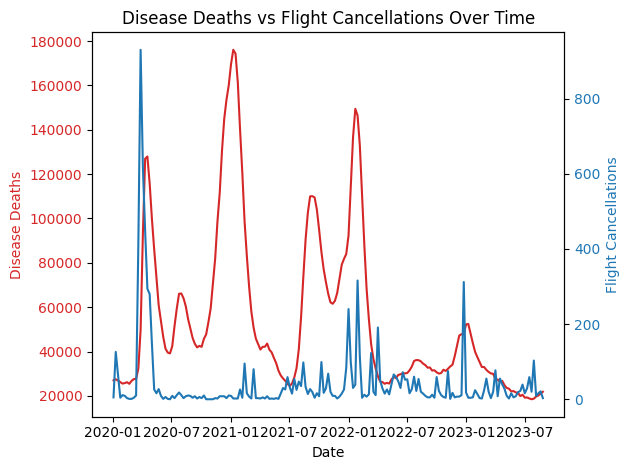

In [41]:
disease_df['Week Ending Date'] = pd.to_datetime(disease_df['Week Ending Date'])
deaths_by_week = disease_df.groupby('Week Ending Date')['Pneumonia, Influenza, or COVID-19 Deaths'].sum().reset_index()

df_filtered['FL_DATE'] = pd.to_datetime(df_filtered['FL_DATE'])
cancellations_by_week = df_filtered.groupby('FL_DATE')['CANCELLED'].sum().reset_index()
merged_data = pd.merge(deaths_by_week, cancellations_by_week, left_on='Week Ending Date', right_on='FL_DATE', how='inner')
fig, ax1 = plt.subplots()

# Plot disease deaths on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Disease Deaths', color='tab:red')
ax1.plot(merged_data['Week Ending Date'], merged_data['Pneumonia, Influenza, or COVID-19 Deaths'], color='tab:red', label='Disease Deaths')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for flight cancellations
ax2 = ax1.twinx()
ax2.set_ylabel('Flight Cancellations', color='tab:blue')
ax2.plot(merged_data['FL_DATE'], merged_data['CANCELLED'], color='tab:blue', label='Flight Cancellations')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Title and show the plot
plt.title('Disease Deaths vs Flight Cancellations Over Time')
fig.tight_layout()  # Adjust layout to fit both y-labels
plt.show()

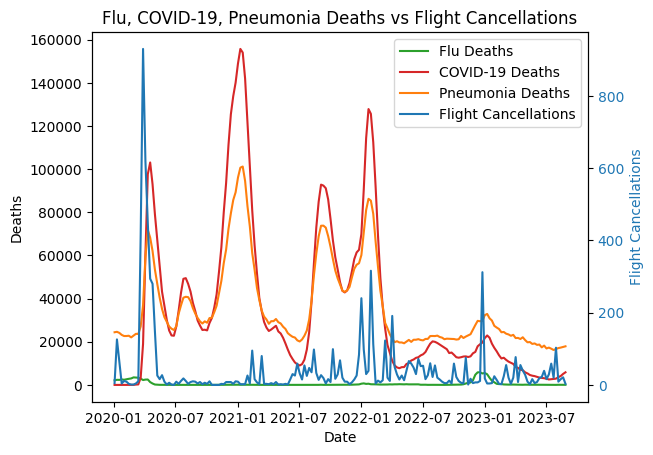

In [45]:
flu_deaths_by_week = disease_df.groupby('Week Ending Date')['Influenza Deaths'].sum().reset_index()
covid_deaths_by_week = disease_df.groupby('Week Ending Date')['COVID-19 Deaths'].sum().reset_index()
pneumonia_deaths_by_week = disease_df.groupby('Week Ending Date')['Pneumonia Deaths'].sum().reset_index()

flu_merged = pd.merge(flu_deaths_by_week, cancellations_by_week, left_on='Week Ending Date', right_on='FL_DATE', how='inner')
covid_merged = pd.merge(covid_deaths_by_week, cancellations_by_week, left_on='Week Ending Date', right_on='FL_DATE', how='inner')
pneumonia_merged = pd.merge(pneumonia_deaths_by_week, cancellations_by_week, left_on='Week Ending Date', right_on='FL_DATE', how='inner')

fig, ax1 = plt.subplots()

# Plot flu, COVID-19, and pneumonia deaths on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Deaths', color='black')
ax1.plot(flu_merged['Week Ending Date'], flu_merged['Influenza Deaths'], color='tab:green', label='Flu Deaths')
ax1.plot(covid_merged['Week Ending Date'], covid_merged['COVID-19 Deaths'], color='tab:red', label='COVID-19 Deaths')
ax1.plot(pneumonia_merged['Week Ending Date'], pneumonia_merged['Pneumonia Deaths'], color='tab:orange', label='Pneumonia Deaths')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for flight cancellations
ax2 = ax1.twinx()
ax2.set_ylabel('Flight Cancellations', color='tab:blue')
ax2.plot(flu_merged['FL_DATE'], flu_merged['CANCELLED'], color='tab:blue', label='Flight Cancellations')  # Full line for cancellations
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Title and legends
plt.title('Flu, COVID-19, Pneumonia Deaths vs Flight Cancellations')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Display the plot
plt.show()

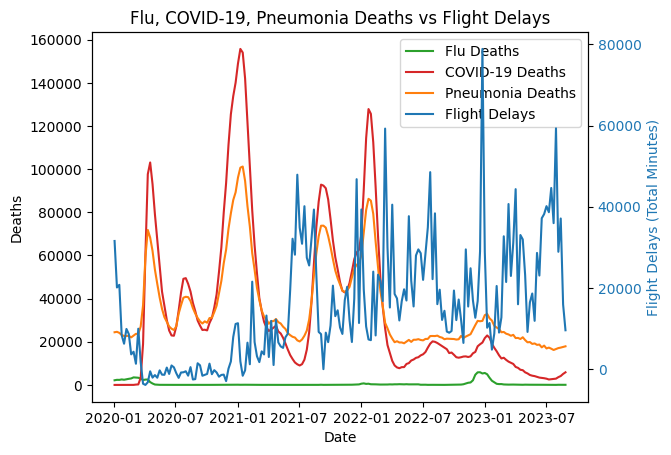

In [46]:
# Step 1: Aggregate flight delays by week
delays_by_week = df_filtered.groupby('FL_DATE')['DEP_DELAY'].sum().reset_index()

# Step 2: Merge flu, COVID-19, and pneumonia deaths with flight delays on the date columns
flu_merged_delays = pd.merge(flu_deaths_by_week, delays_by_week, left_on='Week Ending Date', right_on='FL_DATE', how='inner')
covid_merged_delays = pd.merge(covid_deaths_by_week, delays_by_week, left_on='Week Ending Date', right_on='FL_DATE', how='inner')
pneumonia_merged_delays = pd.merge(pneumonia_deaths_by_week, delays_by_week, left_on='Week Ending Date', right_on='FL_DATE', how='inner')

# Step 3: Plot flu, COVID-19, and pneumonia deaths together vs flight delays
fig, ax1 = plt.subplots()

# Plot flu, COVID-19, and pneumonia deaths on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Deaths', color='black')
ax1.plot(flu_merged_delays['Week Ending Date'], flu_merged_delays['Influenza Deaths'], color='tab:green', label='Flu Deaths')
ax1.plot(covid_merged_delays['Week Ending Date'], covid_merged_delays['COVID-19 Deaths'], color='tab:red', label='COVID-19 Deaths')
ax1.plot(pneumonia_merged_delays['Week Ending Date'], pneumonia_merged_delays['Pneumonia Deaths'], color='tab:orange', label='Pneumonia Deaths')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for flight delays
ax2 = ax1.twinx()
ax2.set_ylabel('Flight Delays (Total Minutes)', color='tab:blue')
ax2.plot(flu_merged_delays['FL_DATE'], flu_merged_delays['DEP_DELAY'], color='tab:blue', label='Flight Delays')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Title and legends
plt.title('Flu, COVID-19, Pneumonia Deaths vs Flight Delays')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')  # Legend at top right corner

# Display the plot
plt.show()


In [23]:
df = pd.read_csv('flights_sample_3m.csv')


In [7]:
df

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,2022-11-13,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,1522,JAX,"Jacksonville, FL",CLT,"Charlotte, NC",...,0.0,85.0,71.0,55.0,328.0,NaN,NaN,NaN,NaN,NaN
2999996,2022-11-02,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,1535,ORD,"Chicago, IL",AUS,"Austin, TX",...,0.0,176.0,145.0,130.0,977.0,NaN,NaN,NaN,NaN,NaN
2999997,2022-09-11,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2745,HSV,"Huntsville, AL",ATL,"Atlanta, GA",...,0.0,55.0,50.0,28.0,151.0,0.0,36.0,0.0,0.0,0.0
2999998,2019-11-13,Republic Airline,Republic Airline: YX,YX,20452,6134,BOS,"Boston, MA",LGA,"New York, NY",...,0.0,88.0,77.0,50.0,184.0,NaN,NaN,NaN,NaN,NaN


In [24]:
from datetime import datetime

# Assuming 'df' is your original DataFrame
cols2del = list(range(1, 20)) + list(range(21, 32))
df2 = df.drop(df.columns[cols2del], axis=1)

# Convert 'FL_DATE' column to datetime with the correct format
df2['FL_DATE'] = pd.to_datetime(df2['FL_DATE'], format='%Y-%m-%d', errors='coerce')

# Verify if the conversion was successful
if df2['FL_DATE'].isnull().any():
    print("Some dates couldn't be converted. Please check the 'FL_DATE' column for inconsistencies.")

# Define start and end dates
start_date = datetime(2019, 12, 29)
end_date = datetime(2023, 10, 28)

# Filter the DataFrame based on 'FL_DATE'
filtered_data = df2[(df2['FL_DATE'] >= start_date) & (df2['FL_DATE'] <= end_date)]


In [25]:
filtered_data
df2

,FL_DATE,CANCELLED
0,2019-01-09,0.0
1,2022-11-19,0.0
2,2022-07-22,0.0
3,2023-03-06,0.0
4,2020-02-23,0.0
...,...,...
2999995,2022-11-13,0.0
2999996,2022-11-02,0.0
2999997,2022-09-11,0.0
2999998,2019-11-13,0.0


In [22]:
df.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT'],
      dtype='object')

In [28]:
filtered_data.to_csv('flights_sample_3m.csv', index=False)

In [29]:
df = pd.read_csv('flights_sample_3m.csv')
df

,FL_DATE,CANCELLED
0,2022-11-19,0.0
1,2022-07-22,0.0
2,2023-03-06,0.0
3,2020-02-23,0.0
4,2023-06-11,0.0
...,...,...
2248503,2021-12-03,0.0
2248504,2020-08-31,0.0
2248505,2022-11-13,0.0
2248506,2022-11-02,0.0
